# Introduction to Optimal Transport on Python
___

Welcome to the first practical session on Optimal Transport Course! Our today's agenda is:
- define main OT objects using `Numpy` library. In particular, we will construct cost matrix that to compute 2-Wasserstein distance;
- Compute OT value using `POT` (`P`ython `O`ptimal `T`ransport) library;
- Visualize objects and optimal plan using `Matplotlib` library and standard tools from `POT` library.

Additionally, we will compute OT problem by building it explicitly as a linear programming problem using `CVXPY` library.

## Imports

In [1]:
import numpy as np  # Our main tool
import ot  # POT library
import matplotlib.pyplot as plt  # For visualization
from ot import plot  # POT tools for visualization
from scipy.stats import norm  # We will use this to construct marginals given by normal distribution

## The problem
___

Recall the optimal transport problem definition.
Let $C \in  \mathbb{R}^{n \times m}$ be a cost matrix, $\rho_1 \in \mathbb{R}^n_{+}$, $\rho_2 \in \mathbb{R}^m_+$ are the probability vectors (i.e. vectors with nonnegative values that sum up to 1) reffered as _marginals_.
Then OT problem is given by

$$
\begin{align*}
\min_{P \in \mathbb{R}^{n \times m}} \quad & \sum_{i=1}^{n} \sum_{j=1}^{m} C_{ij} P_{ij} \\
\text{s. t. } \quad & \sum_{j=1}^{m} P_{ij} = \rho_{1, i} \quad \text{for all } i = 1,\dots,n \\
& \sum_{i=1}^{n} P_{ij} = \rho_{2, j} \quad \text{for all } j = 1,\dots,m \\
& P_{ij} \geq 0 \quad \text{for all } i = 1,\dots,n \text{ and } j = 1,\ldots,m.
\end{align*}
$$

The minimizer of the problem $P^*$ is called _transport map_ or _optimal coupling_.
It is doubly stochastic matrix, i.e. a matrix that has nonnegative entries which sum up to 1.

## Cost Matrix
___

Let's consider a particular case of OT problem widely known as a 2-Wasserstein distance $W_2^2$.
$W_2(\rho_1, \rho_2)$ defines a distance between probability measures $\rho_1$ and $\rho_2$.
Given that two probability measures $\rho_1$ and $\rho_2$ have support $X \in \mathbb{R}^n, Y \in \mathbb{R}^m$, respectively, $W_2^2(\rho_1, \rho_2)$ becomes an OT problem defined as above with the following cost matrix
$$
    C_{ij} = |x_i - y_j|^2 \quad \text{for all } i = 1,\dots,n \text{ and } j = 1,\dots,m.
$$

**How to construct this matrix?** One may use nesting loops to construct such matrix. However, this is highly inefficient way. Instead, we will use the feature of `Numpy` called broadcasting which makes things much simpler.

In [2]:
n = 100  # Size of the first marginal mu
m = 150  # Size of the second marginal nu
X = np.linspace(-10, 10, n)  # Support of mu
Y = np.linspace(-10, 10, m)  # Support of nu

C = (X[:, None] - Y[None, :]) ** 2  # Brief and efficient way; here, None is an alias for np.newaxis
C.shape

(100, 150)

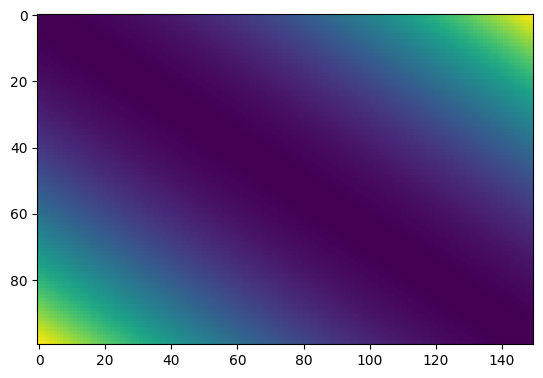

In [3]:
plt.imshow(C)  # Visualize cost matrix

## Define Marginals
___
Next, we need to define the probability vectors.
As a typical example, let's take both $\mu$ and $\nu$ the normal distributions on their support.

In [4]:
mean1 = 5.  # Mean of the first marginal
std1 = 2.5  # Standard deviation (or sqrt(variance)) of the first marginal
rho1 = norm.pdf(X, loc=mean1, scale=std1)
rho1 /= rho1.sum()  # Normalize to 1

mean2 = -5.
std2 = 2.
rho2 = norm.pdf(Y, loc=mean2, scale=std2)
rho2 /= rho2.sum()

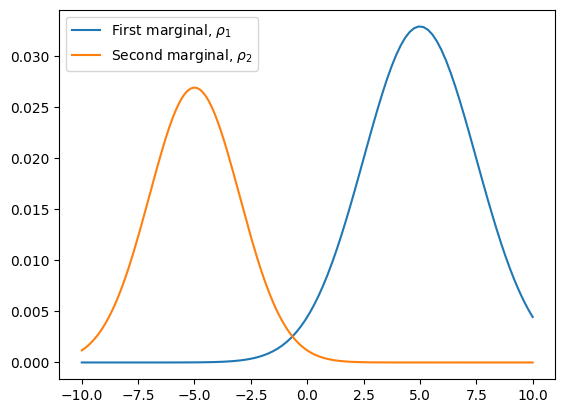

In [5]:
plt.plot(X, rho1, label=r'First marginal, $\rho_1$')
plt.plot(Y, rho2, label=r'Second marginal, $\rho_2$')
plt.legend()

## Solve OT using POT solver
___
`POT` library has plenty of OT algorithms implemented.
In particular, `ot.emd` (`e`arth `m`over's `d`istance) solves OT problem using adaptation of simplex method - well known LP solver algorithm.
With this function, computation of transport plan is straightforward and simple:

In [6]:
P_star = ot.emd(rho1, rho2, C)
opt_val_pot = np.vdot(C, P_star)
print('Optimal value is: ', opt_val_pot)

Optimal value is:  97.04812279078357


### Visualization using POT library
___
`POT` library provides very handy visualization tool which aligns marginals to the respective axes of the transportation plan:

(<Axes: >, <Axes: >, <Axes: >)

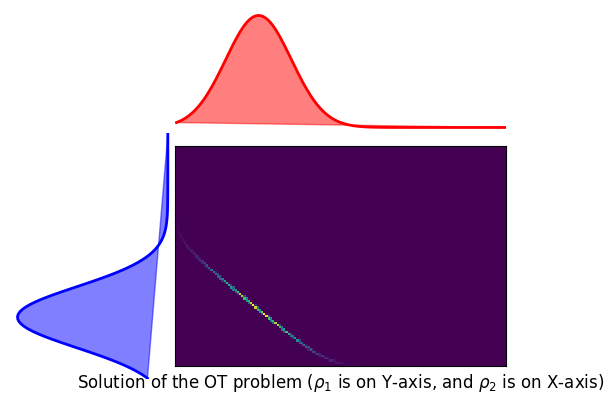

In [7]:
plot.plot1D_mat(rho1, rho2, P_star, r'Solution of the OT problem ($\rho_1$ is on Y-axis, and $\rho_2$ is on X-axis)', coupling_cmap='viridis')

## Extra: Solve OT using CVXPY
___

`CVXPY` provides a framework for constructing convex optimization problem.
It includes not only linear programming, but also quadratic programming, semidefinite programming, etc.
Below we will express an OT problem as an LP problem to further solve it using the solvers available on `CVXPY` (there are a bunch of them, each suitable for particular applications. You can find more information about the solvers [here](https://www.cvxpy.org/tutorial/solvers/index.html#choosing-a-solver)).

In [8]:
import cvxpy as cp  # Our main tool here

**Constraints.** To express OT problem as LP problem, we must understand what it means.
Linear programming problem is standard form is given by
$$
\begin{align*}
\min_{x \in \mathbb{R}^n} \quad & c^\top x \\
\text{s. t. } \quad & A x = b \\
& x_i \geq 0 \quad \text{for all } i = 1, \dots, n,
\end{align*}
$$
where $c \in \mathbb{R}^n,\ A \in \mathbb{R}^{m \times n},\ b \in \mathbb{R}^m$.

In optimal transport, we need to rewrite the problem slightly to unveil its close ties with linear programming:
1. Go from matrices to vectors: $c = \operatorname{vec}(C) \equiv (C_{1 1}, \dots C_{n 1}, \dots, C_{1 m}, \dots, C_{n m}),\ x = \operatorname{vec}(P)$;
2. Nonnegativity constraints are the same: $P \geq 0 \iff x \geq 0$;

In [9]:
c = C.reshape(-1, order='F')  # Flatten cost matrix

The missing part is the constraints.
For the first marginal, we can notice
$$
\begin{align*}
    \begin{pmatrix}
        P_{1 1} + \dots + P_{1 m} \\
        \vdots \\
        P_{n 1} + \dots + P_{n m}
    \end{pmatrix}
    =
    \begin{pmatrix}
        p_1^\top \textbf{1}_m \\
        \vdots \\
        p_n^\top \textbf{1}_m
    \end{pmatrix}
    = P \textbf{1}_m,
\end{align*}
$$
where $\textbf{1}_m \in \mathbb{R}^m$ is the vector of ones, and $p_i^\top$ is $i$-th row of $P$.
Next, we need to use _vectorization identity_
$$
\operatorname{vec}(A X B) = (B^\top \otimes A) \operatorname{vec}(X)
$$
for any $A \in \mathbb{R}^{a \times b},\ X \in \mathbb{R}^{b \times c},\ B \in \mathbb{R}^{c \times d}$.
Above, $\otimes$ denotes Kronecker product.

In particular case of $A = \mathbb{1}_n \in \mathbb{R}^{n \times n}$ (identity matrix), $X = P \in \mathbb{R}^{n \times m},\ \textbf{1}_m \in \mathbb{R}^m$, we have
$$
P \textbf{1}_m
= \operatorname{vec}(P \textbf{1}_m)
= (\textbf{1}_m^\top \otimes \mathbb{1}_n) \operatorname{vec}(P)
= (\textbf{1}_m^\top \otimes \mathbb{1}_n) x,
$$
where $A_1 = \textbf{1}_m^\top \otimes \mathbb{1}_n \in \mathbb{R}^{n \times (n m)}$ is constraint matrix for the first marginal.

Similar for the second marginal, we get
$$
\begin{align*}
    \begin{pmatrix}
        P_{1 1} + \dots + P_{n 1} \\
        \vdots \\
        P_{1 m} + \dots + P_{n m}
    \end{pmatrix}
    = P^\top \textbf{1}_n.
\end{align*}
$$
And, with little caveat in the derivation, we obtain
$$
P^\top \textbf{1}_n
= (\mathbb{1}_m \otimes \textbf{1}_n^\top) \operatorname{vec}(P)
= (\mathbb{1}_m \otimes \textbf{1}_n^\top) x,
$$
where $A_2 = \mathbb{1}_m \otimes \textbf{1}_n^\top \in \mathbb{R}^{m \times (n m)}$.

Finally, for $A_{\mathrm{OT}}=\begin{pmatrix}A_1 \\ A_2 \end{pmatrix}$ and $b_{OT} = \begin{pmatrix}\rho_1 \\ \rho_2 \end{pmatrix}$ give the OT constraint in standard form of linear programming problem.

Let us build them now!

In [10]:
In = np.eye(n)  # mxm identity matrix
one_m = np.ones((m, 1))  # n-dim row vector of ones
A1 = np.kron(one_m.T, In)  # Use np.kron for Kronecker product

Im = np.eye(m)
ones_n = np.ones((n,1))
A2 = np.kron(Im, ones_n.T)

A1.shape, A2.shape

((100, 15000), (150, 15000))

Let's make sure that $A_1$ and $A_2$ are constructed correctly - if we flatten $P^*$, then applying matrices should give the marginals

In [11]:
x_star = P_star.reshape(-1, order='F')
print("Error in the first marginal: ", np.linalg.norm(rho1 - A1 @ x_star))
print("Error in the second marginal: ", np.linalg.norm(rho2 - A2 @ x_star))

Error in the first marginal:  6.109496077370083e-17
Error in the second marginal:  5.081613626395003e-17


Define now `CVXPY` objects.
Below, $x$ defines an object for primal variable which will be forced to be nonnegative thanks to `nonneg=True`:

In [12]:
x = cp.Variable(n * m, nonneg=True)

Constraints are defined in a straightforward way - we don't need to convert `Numpy` arrays to specific `CVXPY` objects.
In fact, interaction with `cp.Variable` already provides necessary information to `CVXPY`:

In [13]:
constraints = [A1 @ x == rho1, A2 @ x == rho2]

Finally, we state the objective:

In [14]:
objective = cp.Minimize(cp.vdot(c, x))

And we collect every piece in `cp.Problem` object:

In [15]:
problem = cp.Problem(objective, constraints)

And solve it:

In [16]:
problem.solve(verbose=True)

(CVXPY) Jan 07 05:40:19 PM: Your problem has 15000 variables, 250 constraints, and 0 parameters.
(CVXPY) Jan 07 05:40:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 07 05:40:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 07 05:40:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 07 05:40:19 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jan 07 05:40:19 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Jan 07 05:40:19 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Jan 07 05:40:19 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 07 05:40:19 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 07 05:40:19 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jan 07 05:40:19 PM: Applying reduction CLARABEL
(CVXPY) Jan 07 05:40:19 PM: Finished problem comp

                                     CVXPY                                     
                                     v1.7.5                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 15000
  constrain

/Users/pavlopelikh/Documents/Dev/OT-Jan-2026/.venv/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jan 07 05:40:20 PM: Problem status: optimal_inaccurate
(CVXPY) Jan 07 05:40:20 PM: Optimal value: 9.705e+01
(CVXPY) Jan 07 05:40:20 PM: Compilation took 3.374e-02 seconds
(CVXPY) Jan 07 05:40:20 PM: Solver (including time spent in interface) took 1.004e+00 seconds


195  +9.7048e+01  +9.7048e+01  1.28e-13  3.56e-08  1.14e-16  1.14e-11  6.07e-11  1.82e-01  
196  +9.7048e+01  +9.7048e+01  1.95e-13  3.92e-08  1.44e-16  1.82e-11  1.03e-10  4.65e-01  
197  +9.7048e+01  +9.7048e+01  1.45e-13  3.41e-08  1.05e-16  1.35e-11  4.94e-11  7.03e-01  
198  +9.7048e+01  +9.7048e+01  1.40e-13  3.80e-08  1.03e-16  1.45e-11  8.14e-11  6.60e-01  
199  +9.7048e+01  +9.7048e+01  2.30e-13  4.85e-08  1.02e-16  2.36e-11  1.37e-10  9.19e-01  
200  +9.7048e+01  +9.7048e+01  2.38e-13  4.64e-08  1.20e-16  2.41e-11  1.38e-10  1.46e-02  
---------------------------------------------------------------------------------------------
Terminated with status = AlmostSolved
solve time = 993.228007ms
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


np.float64(97.04817912849923)

Collect optimal value:

In [17]:
opt_val_cvxpy = problem.value

abs(opt_val_cvxpy - opt_val_pot), opt_val_cvxpy > opt_val_pot  # Difference with optimal value we obtained earlier using POT

(np.float64(5.6337715662380106e-05), np.True_)

And optimal transport plan according to cvxpy:

L2 difference with previously obtained plan:  1.3449766901778026e-06


(<Axes: >, <Axes: >, <Axes: >)

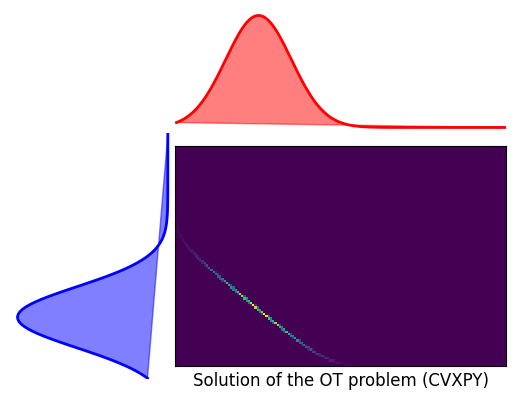

In [18]:
P_star_cvxpy = x.value
P_star_cvxpy = P_star_cvxpy.reshape((n, m), order='F')  # Unflatten the plan

print('L2 difference with previously obtained plan: ', np.linalg.norm(P_star_cvxpy - P_star))
plot.plot1D_mat(rho1, rho2, P_star_cvxpy, 'Solution of the OT problem (CVXPY)', coupling_cmap='viridis')

Above, we can see that optimal value that `CVXPY` returned is slightly larger than the one obtained using `POT`, which suggests that the `CVXPY` solution is less accurate.
However, this behaviour is expected, since `POT` implements method tailored specifically for optimal transport, whereas `CVXPY` uses general-purpose solver designed to handle a much broader class of optimization problems.
It provides a powerful tool for expressing optimization problems in an intuitive way and passing them to solvers.

Below, there's a way of expressing OT problem even without introducing constraint matrices:

In [19]:
X = cp.Variable((n, m), nonneg=True)
constraints2 = [X.sum(1) == rho1, X.sum(0) == rho2]
objective2 = cp.Minimize(cp.vdot(C, X))
problem2 = cp.Problem(objective2, constraints2)
problem2.solve(verbose=True)

(CVXPY) Jan 07 05:40:20 PM: Your problem has 15000 variables, 250 constraints, and 0 parameters.
(CVXPY) Jan 07 05:40:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 07 05:40:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 07 05:40:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 07 05:40:20 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jan 07 05:40:20 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Jan 07 05:40:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Jan 07 05:40:20 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 07 05:40:20 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 07 05:40:20 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jan 07 05:40:20 PM: Applying reduction CLARABEL
(CVXPY) Jan 07 05:40:20 PM: Finished problem comp

                                     CVXPY                                     
                                     v1.7.5                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 15000
  constrain

(CVXPY) Jan 07 05:40:21 PM: Problem status: optimal_inaccurate
(CVXPY) Jan 07 05:40:21 PM: Optimal value: 9.705e+01
(CVXPY) Jan 07 05:40:21 PM: Compilation took 1.522e-02 seconds
(CVXPY) Jan 07 05:40:21 PM: Solver (including time spent in interface) took 1.018e+00 seconds


197  +9.7048e+01  +9.7048e+01  1.45e-13  3.41e-08  1.05e-16  1.35e-11  4.94e-11  7.03e-01  
198  +9.7048e+01  +9.7048e+01  1.40e-13  3.80e-08  1.03e-16  1.45e-11  8.14e-11  6.60e-01  
199  +9.7048e+01  +9.7048e+01  2.30e-13  4.85e-08  1.02e-16  2.36e-11  1.37e-10  9.19e-01  
200  +9.7048e+01  +9.7048e+01  2.38e-13  4.64e-08  1.20e-16  2.41e-11  1.38e-10  1.46e-02  
---------------------------------------------------------------------------------------------
Terminated with status = AlmostSolved
solve time = 1.006462567s
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


np.float64(97.04817912849923)

In [20]:
opt_val_cvxpy2 = problem2.value
P_star_cvxpy2 = X.value

print('Difference with previous CVXPY optimal value: ', opt_val_cvxpy - opt_val_cvxpy2)
print('L2 difference between CVXPY optimal plans: ', np.linalg.norm(P_star_cvxpy2 - P_star_cvxpy))

Difference with previous CVXPY optimal value:  0.0
L2 difference between CVXPY optimal plans:  0.0
